# W10 - KMeans and Hierarchical Clustering (Scaled vs Unscaled Data)
##  0706022310044 - Heidy Mudita Sutedjo

## Part A - Data Preparation

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score

### Data Understanding

In [121]:
# load dataset and show the first five sample
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/customer_classification_data.csv"
df = pd.read_csv(url)
df.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,66161.01279,57,Bachelor,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693
1,78639.20248,60,High School,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358
2,70207.25321,46,High School,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993
3,65866.23872,42,High School,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473
4,56774.10995,36,Bachelor,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168


In [122]:
# describe data
df.describe()

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,62244.823110,40.010000,564.992000,10.806000,48.486000,5062.825191,25395.518396,10609.972452,0.512753,2.564000,0.494516
std,21881.731581,13.051229,159.206663,5.151061,28.742339,2926.414765,14257.083307,5572.250431,0.282915,1.101058,0.294468
min,25352.160710,18.000000,300.000000,1.000000,1.000000,44.900440,1087.318821,1017.345471,0.000813,1.000000,0.001320
25%,43586.942127,29.000000,426.000000,7.000000,25.000000,2563.861164,13254.375542,5788.708258,0.272196,2.000000,0.239926
50%,61513.145375,39.000000,562.000000,11.000000,48.000000,4962.940262,25523.286385,10716.457885,0.531370,3.000000,0.485326
75%,79805.933200,51.000000,692.000000,15.000000,72.000000,7575.192218,38359.706343,15530.730127,0.763411,4.000000,0.759197
max,99913.525490,64.000000,849.000000,19.000000,99.000000,9984.440444,49971.895230,19968.520560,0.993942,4.000000,0.999897


In [123]:
# Check for info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 500 non-null    float64
 1   Age                    500 non-null    int64  
 2   Education              500 non-null    object 
 3   Credit_Score           500 non-null    int64  
 4   Years_with_Bank        500 non-null    int64  
 5   Transaction_Count      500 non-null    int64  
 6   Balance                500 non-null    float64
 7   Loan_Approval_Amount   500 non-null    float64
 8   Credit_Card_Limit      500 non-null    float64
 9   Purchase_Frequency     500 non-null    float64
 10  Customer_Satisfaction  500 non-null    int64  
 11  Online_Activity        500 non-null    float64
dtypes: float64(6), int64(5), object(1)
memory usage: 47.0+ KB


### Data Understanding Summary

This dataset contains 500 entries and 12 columns with no missing values in any of the columns. There is only one categorical column, the rest are numerical.

Meanwhile the range for each column are very different, so scaling is needed to get a better clustering result.

### Encoding

In [124]:
for column in df.columns:
    unique_count = df[column].nunique()
    print(f"Column '{column}': {unique_count} unique values")
    if unique_count < 20:
        print(f"  Unique values: {df[column].unique()}")
    print("-" * 30)

Column 'Income': 500 unique values
------------------------------
Column 'Age': 47 unique values
------------------------------
Column 'Education': 4 unique values
  Unique values: ['Bachelor' 'High School' 'PhD' 'Master']
------------------------------
Column 'Credit_Score': 328 unique values
------------------------------
Column 'Years_with_Bank': 19 unique values
  Unique values: [ 1  2 14 17 12 15  9  4 10 18  6  8  5 16  7 19 11  3 13]
------------------------------
Column 'Transaction_Count': 98 unique values
------------------------------
Column 'Balance': 500 unique values
------------------------------
Column 'Loan_Approval_Amount': 500 unique values
------------------------------
Column 'Credit_Card_Limit': 500 unique values
------------------------------
Column 'Purchase_Frequency': 500 unique values
------------------------------
Column 'Customer_Satisfaction': 4 unique values
  Unique values: [1 2 3 4]
------------------------------
Column 'Online_Activity': 500 unique val

In [125]:
# Encoding categorical column 'Education'
education_order = ['High School', 'Bachelor', 'Master', 'PhD']
ordinal_encoder = OrdinalEncoder(categories=[education_order])
df['Education'] = ordinal_encoder.fit_transform(df[['Education']])

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Income                 500 non-null    float64
 1   Age                    500 non-null    int64  
 2   Education              500 non-null    float64
 3   Credit_Score           500 non-null    int64  
 4   Years_with_Bank        500 non-null    int64  
 5   Transaction_Count      500 non-null    int64  
 6   Balance                500 non-null    float64
 7   Loan_Approval_Amount   500 non-null    float64
 8   Credit_Card_Limit      500 non-null    float64
 9   Purchase_Frequency     500 non-null    float64
 10  Customer_Satisfaction  500 non-null    int64  
 11  Online_Activity        500 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 47.0 KB


Now, all columns are numerical

## Part B - Exploratory Data Analysis

/tmp/ipython-input-2890215336.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Customer_Satisfaction', data=df, palette='viridis')


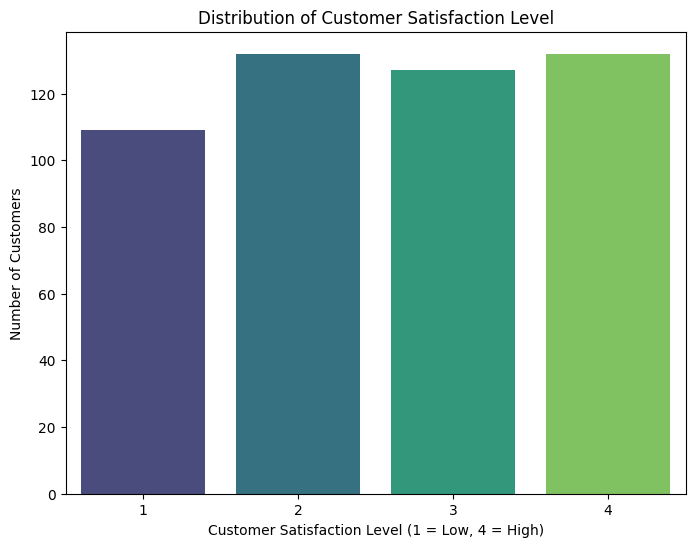

In [127]:
# Bar chart showing Customer Satisfaction Level
plt.figure(figsize=(8, 6))
sns.countplot(x='Customer_Satisfaction', data=df, palette='viridis')
plt.title('Distribution of Customer Satisfaction Level')
plt.xlabel('Customer Satisfaction Level (1 = Low, 4 = High)')
plt.ylabel('Number of Customers')
plt.show()

This chart shows a relatively even distribution of customer satisfaction across levels 2, 3, and 4, with a slight down at level 1 (lowest satisfaction), indicating a balanced spread rather than extreme highs or lows.

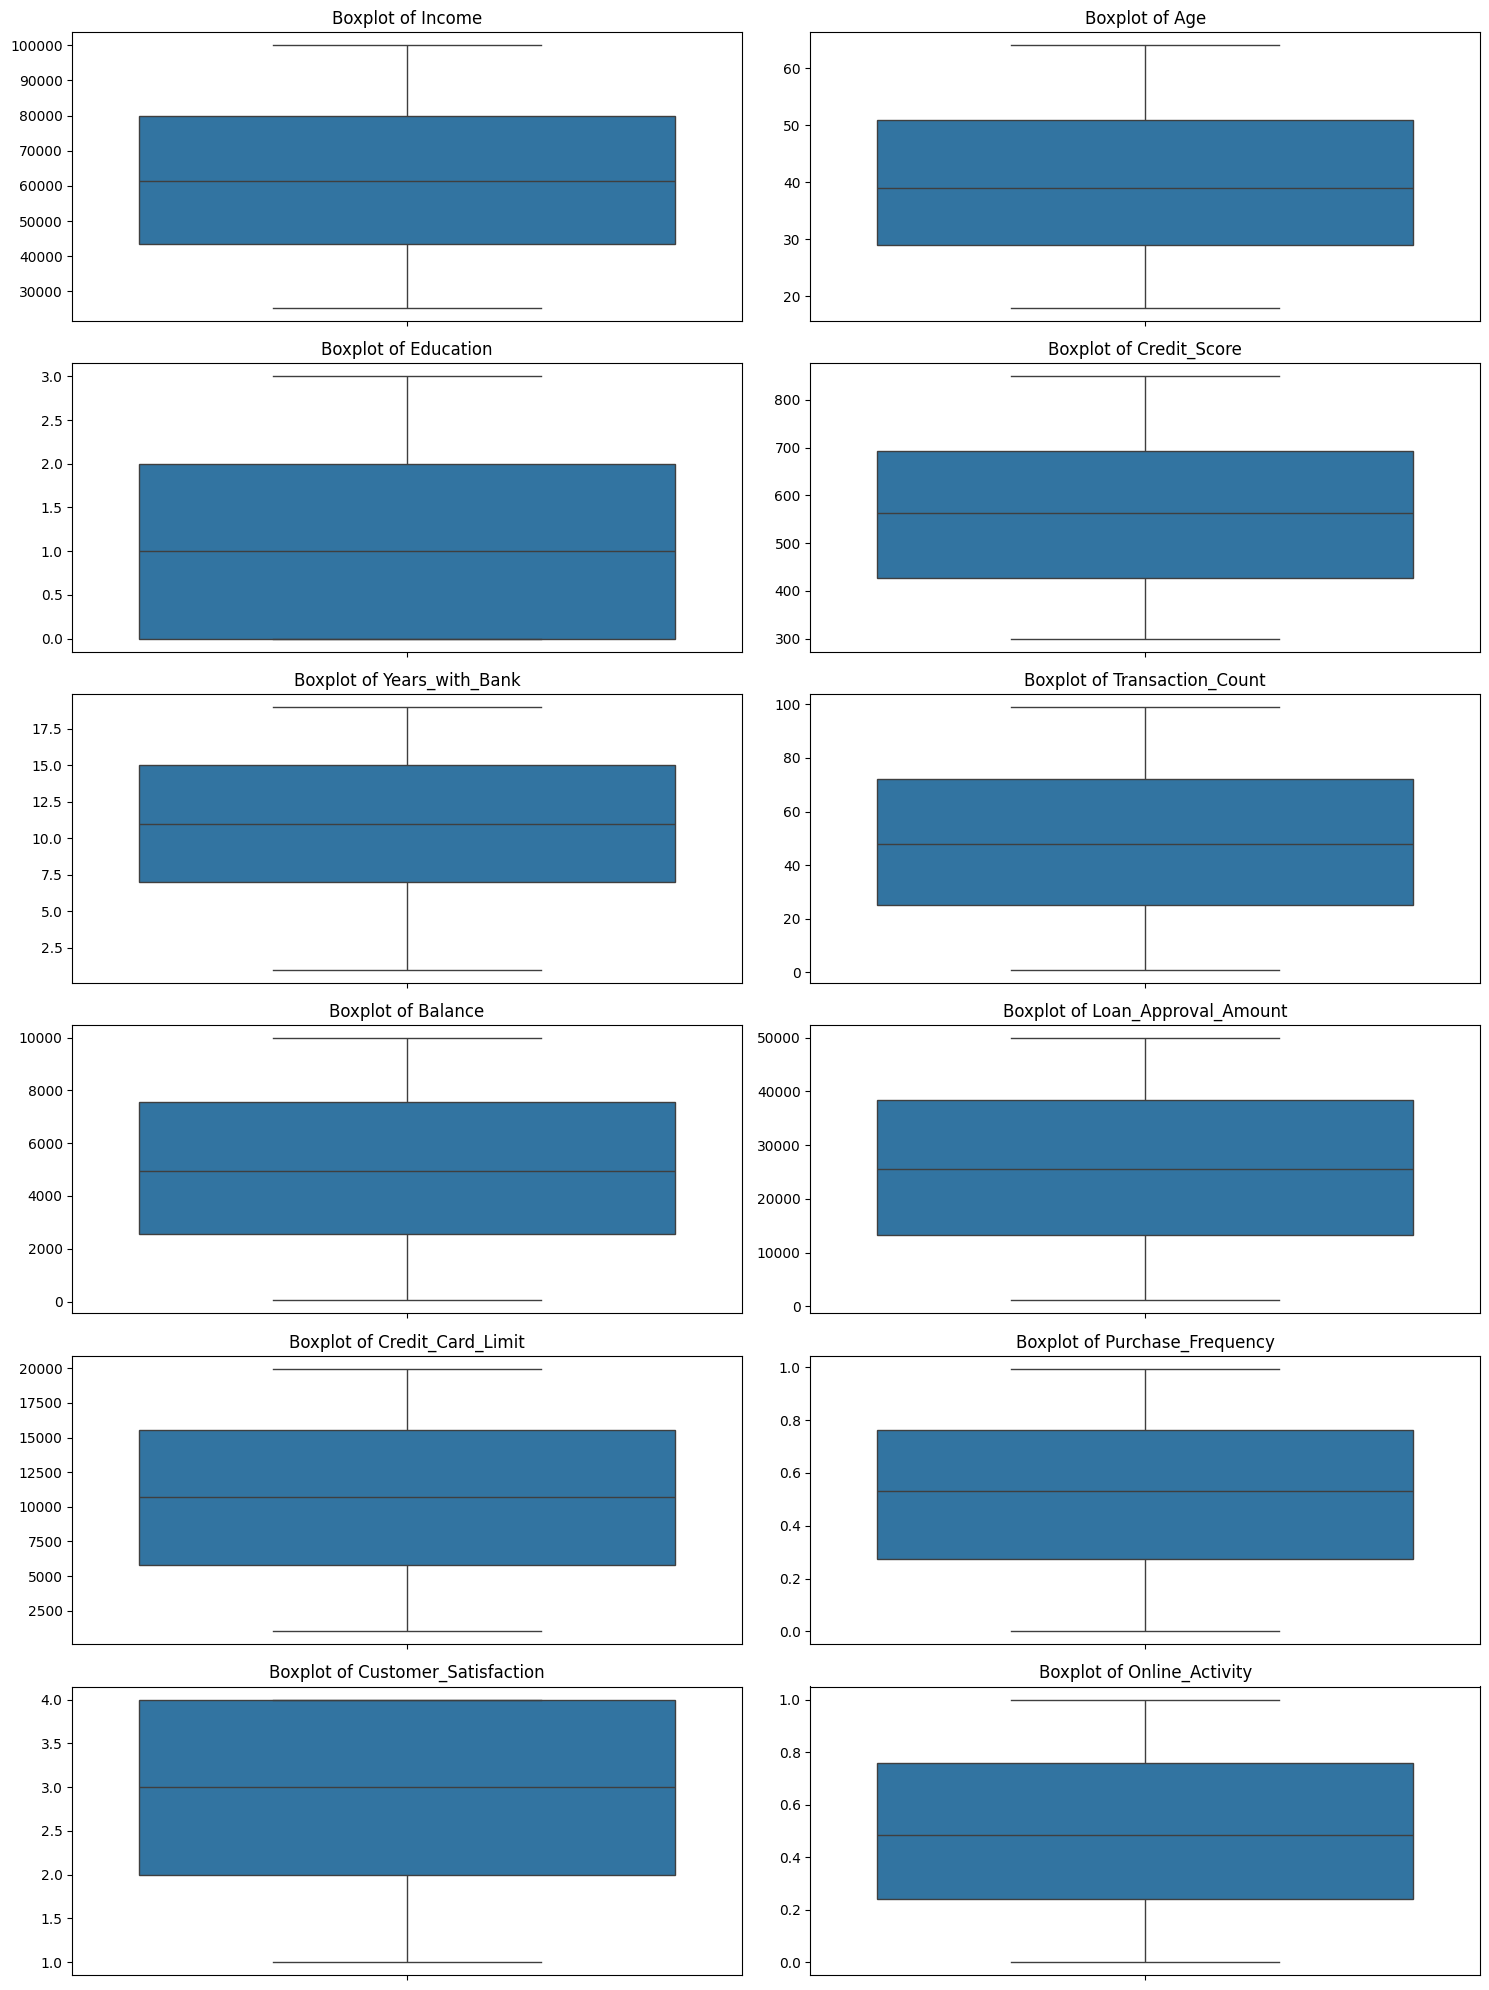

In [128]:
num_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(15, 20))
for i, column in enumerate(num_cols):
    plt.subplot(6, 2, i + 1) # Adjust grid size as needed
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

The boxplots reveal that most features exhibit well-contained distributions with no significant or extreme outliers detected, which suggests a generally clean dataset in this regard.

## Part C - Clustering Modeling
### Using Agglomerative (Hierarchical) Clustering

In [129]:
# Create a StandardScaler object
sc = StandardScaler()

# Select all numerical columns, then exclude 'Education'
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'Education' in numerical_cols:
    numerical_cols.remove('Education')

# Fit and transform the selected columns
df_scaled = sc.fit_transform(df[numerical_cols])

# Create a DataFrame from the scaled columns
df_scaled = pd.DataFrame(df_scaled, columns=numerical_cols, index=df.index)

display(df_scaled.head())

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
0,0.179150,1.303097,-0.389771,-1.905592,-0.260713,-1.058293,-1.606308,-0.861669,1.636958,-1.421875,-0.992013
1,0.749977,1.533191,1.345561,-1.711263,-0.748287,1.619378,0.428724,-1.189034,1.532620,-0.512748,0.186427
2,0.364249,0.459420,-0.289172,0.620687,1.619930,0.670893,-0.628469,-0.821645,-0.849476,0.396379,1.184595
3,0.165665,0.152629,1.691370,1.203675,0.993049,1.002068,1.392847,-1.422533,1.067226,1.305506,-1.274907
4,-0.250263,-0.307558,-0.974502,0.232029,0.331341,-1.547513,1.628264,-0.083694,-0.588149,1.305506,1.684898


In [130]:
# get stastical information on the new dataset
df_scaled.describe()

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,2.158274e-16,1.421085e-16,2.593481e-16,1.598721e-16,9.237056e-17,-3.392842e-16,-1.918465e-16,4.085621e-17,1.492140e-16,-4.973799e-17,-8.171241e-17
std,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,-1.687691e+00,-1.688120e+00,-1.666120e+00,-1.905592e+00,-1.653782e+00,-1.716418e+00,-1.706699e+00,-1.723224e+00,-1.811333e+00,-1.421875e+00,-1.676552e+00
25%,-8.535233e-01,-8.444436e-01,-8.739031e-01,-7.396169e-01,-8.179404e-01,-8.547889e-01,-8.524396e-01,-8.660940e-01,-8.511311e-01,-5.127476e-01,-8.654451e-01
50%,-3.347132e-02,-7.746485e-02,-1.881200e-02,3.769986e-02,-1.692579e-02,-3.416637e-02,8.970695e-03,1.912909e-02,6.587104e-02,3.963794e-01,-3.124291e-02
75%,8.033504e-01,8.429096e-01,7.985545e-01,8.150166e-01,8.189156e-01,8.593735e-01,9.102263e-01,8.839671e-01,8.868705e-01,1.305506e+00,8.997453e-01
max,1.723192e+00,1.839982e+00,1.785682e+00,1.592333e+00,1.759237e+00,1.683474e+00,1.725528e+00,1.681174e+00,1.702529e+00,1.305506e+00,1.717971e+00


As you can see, the features are now comparable in scale.

In [131]:
df_unscaled = df.drop('Education', axis=1)
df_unscaled.describe()

,Income,Age,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,62244.823110,40.010000,564.992000,10.806000,48.486000,5062.825191,25395.518396,10609.972452,0.512753,2.564000,0.494516
std,21881.731581,13.051229,159.206663,5.151061,28.742339,2926.414765,14257.083307,5572.250431,0.282915,1.101058,0.294468
min,25352.160710,18.000000,300.000000,1.000000,1.000000,44.900440,1087.318821,1017.345471,0.000813,1.000000,0.001320
25%,43586.942127,29.000000,426.000000,7.000000,25.000000,2563.861164,13254.375542,5788.708258,0.272196,2.000000,0.239926
50%,61513.145375,39.000000,562.000000,11.000000,48.000000,4962.940262,25523.286385,10716.457885,0.531370,3.000000,0.485326
75%,79805.933200,51.000000,692.000000,15.000000,72.000000,7575.192218,38359.706343,15530.730127,0.763411,4.000000,0.759197
max,99913.525490,64.000000,849.000000,19.000000,99.000000,9984.440444,49971.895230,19968.520560,0.993942,4.000000,0.999897


Comparing to the features scaled above, the features are not comparable in scale.

We are going to use these 2 df for clustering.

### Silhouette Score

#### Scaled Data

In [132]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score = -1
best_n_clusters = 0
best_linkage = ''
best_metric = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            # Use only the scaled numerical columns for clustering
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_scaled)
            silhouette_avg = silhouette_score(df_scaled, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_n_clusters = n_clusters
                best_linkage = linkage_method
                best_metric = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

Skipping Ward linkage with Manhattan metric (not supported).
Best Silhouette Score: 0.11028032059064112
Optimal Number of Clusters: 2
Optimal Linkage Method: average
Optimal Metric: manhattan


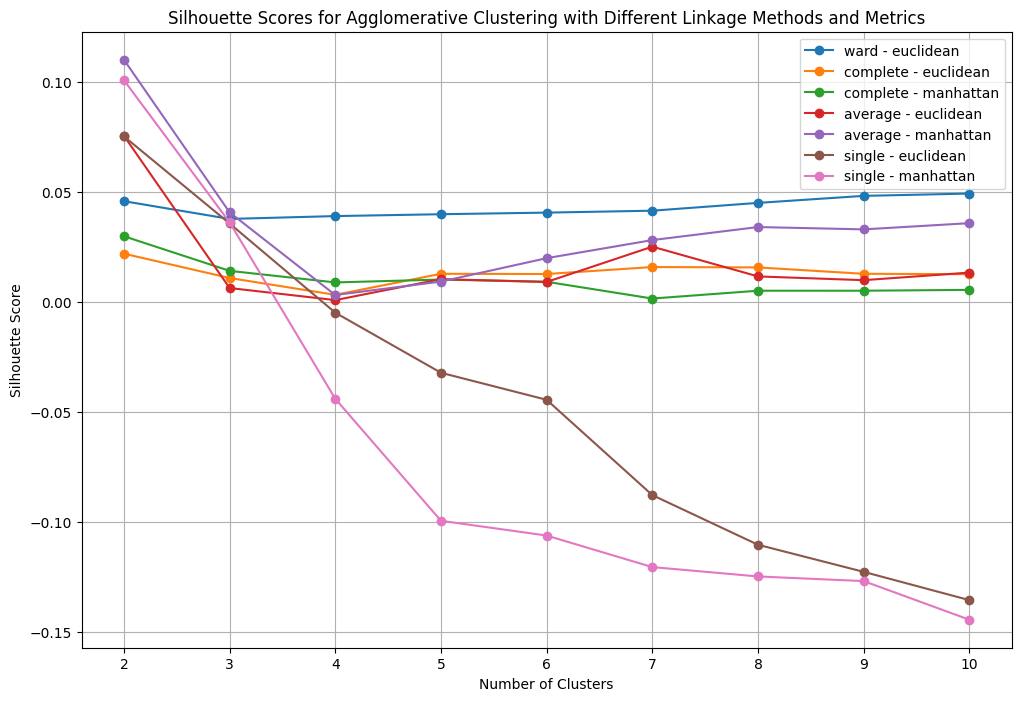

Best Silhouette Score: 0.11028032059064112
Optimal Number of Clusters: 2
Optimal Linkage Method: average
Optimal Metric: manhattan


In [133]:
# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score}")
print(f"Optimal Number of Clusters: {best_n_clusters}")
print(f"Optimal Linkage Method: {best_linkage}")
print(f"Optimal Metric: {best_metric}")

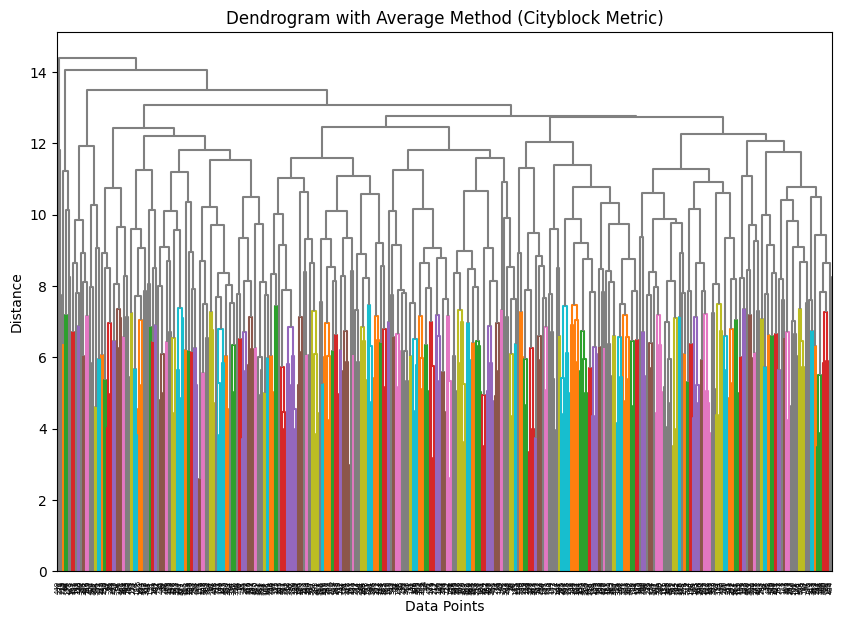

In [134]:
# Best Method
linked = linkage(df_scaled, method='average', metric='cityblock')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, above_threshold_color="grey", color_threshold=7.5)
plt.title("Dendrogram with Average Method (Cityblock Metric)")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

In [135]:
# Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=best_linkage, metric=best_metric)
y_hc = agglo.fit_predict(df_scaled)

#### Unscaled

In [136]:
# Define the range of clusters to test and linkage methods
range_n_clusters = range(2, 11)
linkage_methods = ['ward', 'complete', 'average', 'single']
metrics = ['euclidean', 'manhattan']

best_silhouette_score_2 = -1
best_n_clusters_2 = 0
best_linkage_2 = ''
best_metric_2 = ''

results_for_plotting = []

for linkage_method in linkage_methods:
    for metric in metrics:
        # Skip 'ward' linkage with 'manhattan' metric as it's not supported
        if linkage_method == 'ward' and metric == 'manhattan':
            print(f"Skipping Ward linkage with Manhattan metric (not supported).")
            continue

        current_scores = []
        for n_clusters in range_n_clusters:
            # Use only the scaled numerical columns for clustering
            agglo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method, metric=metric)
            y_agglo = agglo.fit_predict(df_unscaled)
            silhouette_avg = silhouette_score(df_unscaled, y_agglo)
            current_scores.append(silhouette_avg)

            if silhouette_avg > best_silhouette_score_2:
                best_silhouette_score_2 = silhouette_avg
                best_n_clusters_2 = n_clusters
                best_linkage_2 = linkage_method
                best_metric_2 = metric
        results_for_plotting.append({
            'linkage': linkage_method,
            'metric': metric,
            'scores': current_scores
        })

print(f"Best Silhouette Score: {best_silhouette_score_2}")
print(f"Optimal Number of Clusters: {best_n_clusters_2}")
print(f"Optimal Linkage Method: {best_linkage_2}")
print(f"Optimal Metric: {best_metric_2}")

Skipping Ward linkage with Manhattan metric (not supported).
Best Silhouette Score: 0.3957270704224104
Optimal Number of Clusters: 2
Optimal Linkage Method: ward
Optimal Metric: euclidean


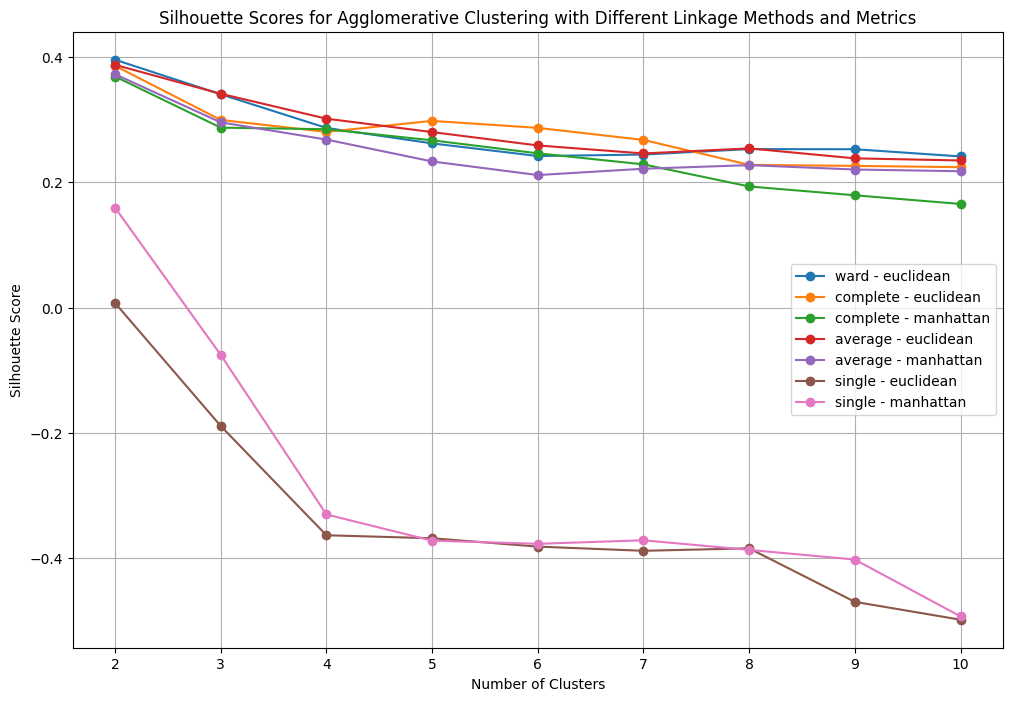

Best Silhouette Score: 0.3957270704224104
Optimal Number of Clusters: 2
Optimal Linkage Method: ward
Optimal Metric: euclidean


In [137]:
# Plot the silhouette scores for each linkage method and metric combination
plt.figure(figsize=(12, 8))
for result in results_for_plotting:
    plt.plot(range_n_clusters, result['scores'], marker='o', label=f"{result['linkage']} - {result['metric']}")

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Agglomerative Clustering with Different Linkage Methods and Metrics")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Silhouette Score: {best_silhouette_score_2}")
print(f"Optimal Number of Clusters: {best_n_clusters_2}")
print(f"Optimal Linkage Method: {best_linkage_2}")
print(f"Optimal Metric: {best_metric_2}")

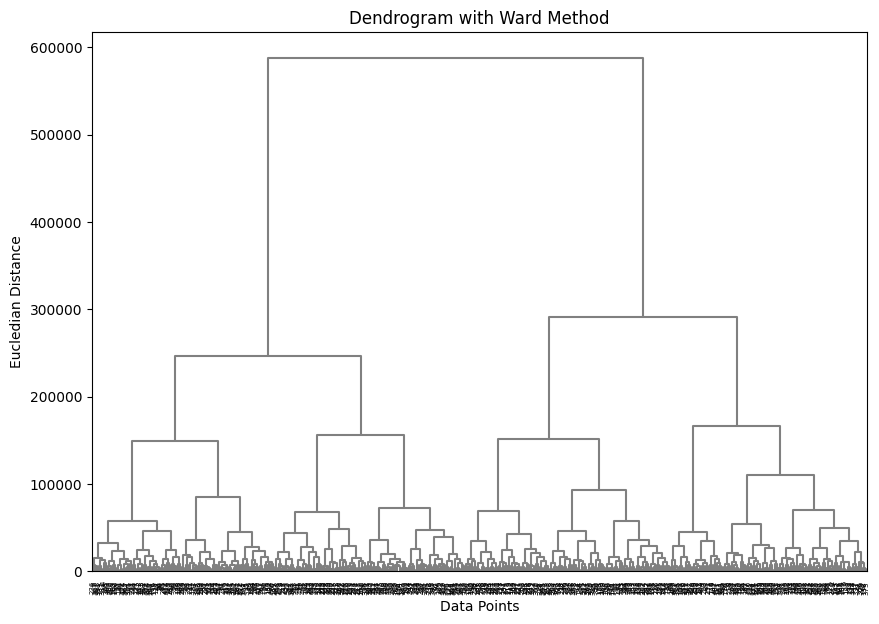

In [138]:
# Best Method
linked = linkage(df_unscaled, method='ward', metric='euclidean')

# Plot dendrogram dengan color_threshold
plt.figure(figsize=(10, 7))
sch.dendrogram(linked, above_threshold_color="grey", color_threshold=7.5)
plt.title("Dendrogram with Ward Method")
plt.xlabel("Data Points")
plt.ylabel("Eucledian Distance")
plt.show()

In [142]:
# Hierarchical Clustering
agglo_unscaled = AgglomerativeClustering(n_clusters=best_n_clusters_2, linkage=best_linkage_2, metric=best_metric_2)
y_hc_unscaled = agglo_unscaled.fit_predict(df_unscaled)

In [143]:
# Evaluation
ss_unscaled = silhouette_score(df_unscaled, y_hc_unscaled)
print(f"Unscaled Data Silhouette Score: {ss_unscaled}")
ss = silhouette_score(df_scaled, y_hc)
print(f"Scaled Data Silhouette Score: {ss}")

Unscaled Data Silhouette Score: 0.3957270704224104
Scaled Data Silhouette Score: 0.11028032059064112


As we can see, the silhouette score for the unscaled dataset is a lot better than using scaled dataset.

### Merge with Original Data

#### Scaled

In [144]:
# Add the cluster labels to the original data
df['Agglo'] = y_hc

# Analyze the clusters with the original values
df.head()

,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Agglo
0,66161.01279,57,1.0,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,0
1,78639.20248,60,0.0,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,0
2,70207.25321,46,0.0,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,0
3,65866.23872,42,0.0,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,0
4,56774.10995,36,1.0,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,0


#### Unscaled

In [145]:
df_hc_unscaled = df.copy()
df_hc_unscaled['Agglo'] = y_hc_unscaled

# Display the head of the new DataFrame to confirm
print("Head of new DataFrame with y_hc_unscaled clusters:")
display(df_hc_unscaled.head())

Head of new DataFrame with y_hc_unscaled clusters:


,Income,Age,Education,Credit_Score,Years_with_Bank,Transaction_Count,Balance,Loan_Approval_Amount,Credit_Card_Limit,Purchase_Frequency,Customer_Satisfaction,Online_Activity,Agglo
0,66161.01279,57,1.0,503,1,41,1968.919899,2517.159284,5813.342700,0.975409,1,0.202693,0
1,78639.20248,60,0.0,779,2,27,9797.056371,31501.758840,3991.007637,0.945920,2,0.549358,0
2,70207.25321,46,0.0,519,14,95,7024.173403,16444.341580,6036.140567,0.272664,3,0.842993,0
3,65866.23872,42,0.0,834,17,77,7992.359261,45233.592940,2691.192862,0.814385,4,0.119473,0
4,56774.10995,36,1.0,410,12,58,538.691042,48586.582480,10144.073090,0.346523,4,0.990168,1


### Cluster Distribution Comparison

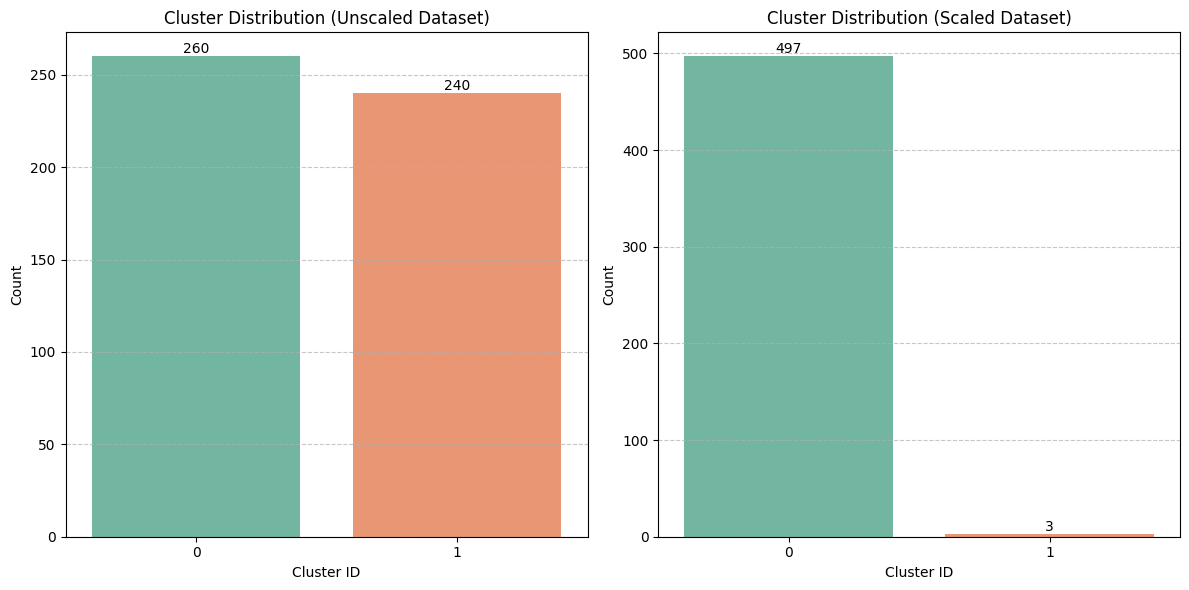

In [146]:
# Get the counts for Unscaled Dataset
cluster_counts_unscaled = pd.Series(y_hc_unscaled).value_counts().sort_index()

# Get the counts for Scaled Dataset (already in df['Agglo'])
cluster_counts_scaled = df['Agglo'].value_counts().sort_index()

# Create bar plot for Unscaled Dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # 1 row, 2 columns, 1st plot
ax1 = sns.barplot(x=cluster_counts_scaled.index, y=cluster_counts_unscaled.values, hue=cluster_counts_unscaled.index, palette='Set2', legend=False)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%d', label_type='edge')
plt.title('Cluster Distribution (Unscaled Dataset)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Create bar plot for Scaled Dataset
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
ax2 = sns.barplot(x=cluster_counts_scaled.index, y=cluster_counts_scaled.values, hue=cluster_counts_scaled.index, palette='Set2', legend=False)
for container in ax2.containers:
    ax2.bar_label(container, fmt='%d', label_type='edge')
plt.title('Cluster Distribution (Scaled Dataset)')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Statistical Summary for each cluster

In [151]:
# Scaled
# Group the data by cluster and calculate summary statistics for each cluster
cluster_summary = df.groupby('Agglo').agg({
    'Income': ['mean', 'std', 'min', 'max'],
    'Age': ['mean', 'std', 'min', 'max'],
    'Education': ['mean', 'std', 'min', 'max'],
    'Credit_Score': ['mean', 'std', 'min', 'max'],
    'Years_with_Bank': ['mean', 'std', 'min', 'max'],
    'Transaction_Count': ['mean', 'std', 'min', 'max'],
    'Balance': ['mean', 'std', 'min', 'max'],
    'Loan_Approval_Amount': ['mean', 'std', 'min', 'max'],
    'Credit_Card_Limit': ['mean', 'std', 'min', 'max'],
    'Purchase_Frequency': ['mean', 'std', 'min', 'max']
})

cluster_summary = cluster_summary.rename_axis('cluster')

display(cluster_summary)

Income                                                Age  \
                 mean           std          min          max       mean   
cluster                                                                    
0        62258.212291  21872.048622  25352.16071  99913.52549  40.070423   
1        60026.682137  28563.257420  40998.39830  92871.12592  30.000000   

                           Education            ... Loan_Approval_Amount  \
               std min max      mean       std  ...                  min   
cluster                                         ...                        
0        13.066250  18  64  1.406439  1.134058  ...          1087.318821   
1         2.645751  28  33  1.000000  1.000000  ...         36805.319880   

                     Credit_Card_Limit                                         \
                 max              mean          std          min          max   
cluster                                                                         
0        49971.89523      10639.636202  5558.222716  1017.345471  19968.52056   
1        45011.10488       5695.677937  6989.447020  1057.503456  13734.71909   

        Purchase_Frequency                                
                      mean       std       min       max  
cluster                                                   
0                 0.509923  0.281402  0.000813  0.993942  
1                 0.981597  0.007790  0.973003  0.988192  

[2 rows x 40 columns]

In [152]:
# Unscaled
# Group the data by cluster and calculate summary statistics for each cluster
cluster_summary_unscaled = df_hc_unscaled.groupby('Agglo').agg({
    'Income': ['mean', 'std', 'min', 'max'],
    'Age': ['mean', 'std', 'min', 'max'],
    'Education': ['mean', 'std', 'min', 'max'],
    'Credit_Score': ['mean', 'std', 'min', 'max'],
    'Years_with_Bank': ['mean', 'std', 'min', 'max'],
    'Transaction_Count': ['mean', 'std', 'min', 'max'],
    'Balance': ['mean', 'std', 'min', 'max'],
    'Loan_Approval_Amount': ['mean', 'std', 'min', 'max'],
    'Credit_Card_Limit': ['mean', 'std', 'min', 'max'],
    'Purchase_Frequency': ['mean', 'std', 'min', 'max']
})

cluster_summary_unscaled = cluster_summary_unscaled.rename_axis('cluster')

display(cluster_summary_unscaled)

Income                                                Age  \
                 mean           std          min          max       mean   
cluster                                                                    
0        80056.384759  12503.832639  48384.69115  99913.52549  40.007692   
1        42948.964656  10547.367150  25352.16071  68181.33715  40.012500   

                           Education            ... Loan_Approval_Amount  \
               std min max      mean       std  ...                  min   
cluster                                         ...                        
0        13.203191  18  64  1.423077  1.154915  ...          1087.318821   
1        12.912153  18  64  1.383333  1.110493  ...          1230.459555   

                     Credit_Card_Limit                                         \
                 max              mean          std          min          max   
cluster                                                                         
0        49971.89523      10299.053313  5412.027733  1123.831875  19659.11871   
1        49820.52773      10946.801520  5733.062270  1017.345471  19968.52056   

        Purchase_Frequency                                
                      mean       std       min       max  
cluster                                                   
0                 0.518549  0.287781  0.000813  0.993942  
1                 0.506474  0.278011  0.001914  0.988192  

[2 rows x 40 columns]

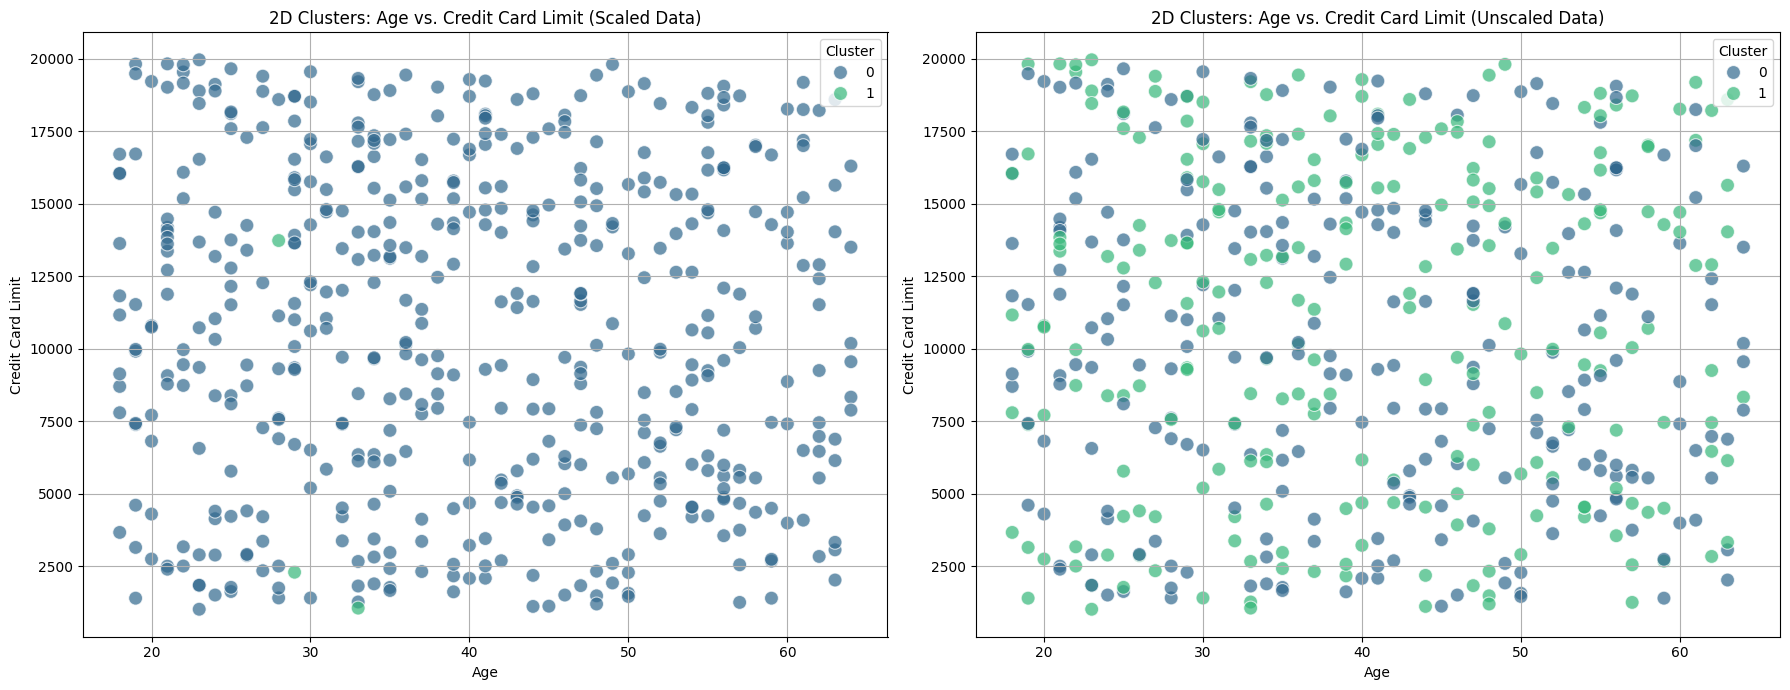

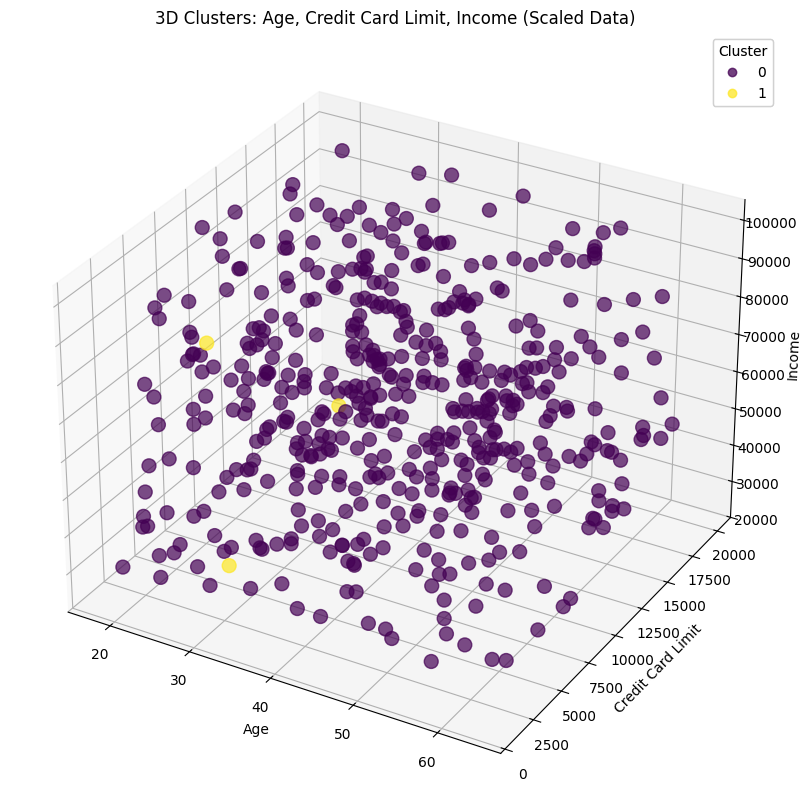

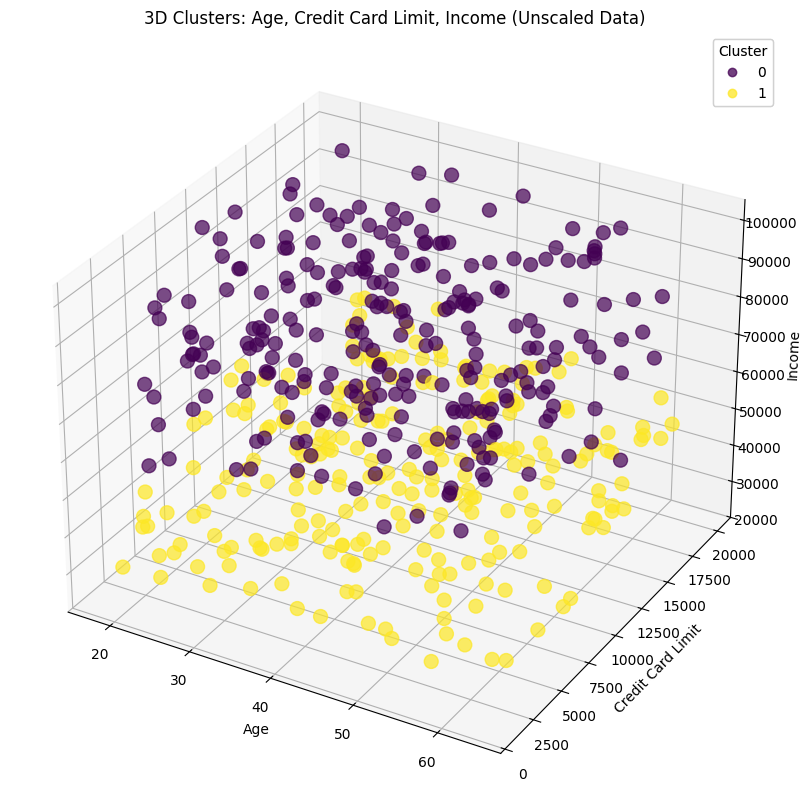

In [153]:
from mpl_toolkits.mplot3d import Axes3D

# 2D Plots
plt.figure(figsize=(18, 7))

# 2D Scaled Data
plt.subplot(1, 2, 1)
sns.scatterplot(x='Age', y='Credit_Card_Limit', hue='Agglo', data=df, palette='viridis', s=100, alpha=0.7)
plt.title('2D Clusters: Age vs. Credit Card Limit (Scaled Data)')
plt.xlabel('Age')
plt.ylabel('Credit Card Limit')
plt.legend(title='Cluster')
plt.grid(True)

# 2D Unscaled Data
plt.subplot(1, 2, 2)
sns.scatterplot(x='Age', y='Credit_Card_Limit', hue='Agglo', data=df_hc_unscaled, palette='viridis', s=100, alpha=0.7)
plt.title('2D Clusters: Age vs. Credit Card Limit (Unscaled Data)')
plt.xlabel('Age')
plt.ylabel('Credit Card Limit')
plt.legend(title='Cluster')
plt.grid(True)

plt.tight_layout()
plt.show()

# 3D Plots
# 3D Scaled Data
fig1 = plt.figure(figsize=(12, 10))
ax1 = fig1.add_subplot(111, projection='3d')
scatter1 = ax1.scatter(df['Age'], df['Credit_Card_Limit'], df['Income'],
                     c=df['Agglo'], cmap='viridis', s=100, alpha=0.7)
ax1.set_xlabel('Age')
ax1.set_ylabel('Credit Card Limit')
ax1.set_zlabel('Income')
ax1.set_title('3D Clusters: Age, Credit Card Limit, Income (Scaled Data)')
legend1 = ax1.legend(*scatter1.legend_elements(), title='Cluster')
ax1.add_artist(legend1)
plt.show()

# 3D Unscaled Data
fig2 = plt.figure(figsize=(12, 10))
ax2 = fig2.add_subplot(111, projection='3d')
scatter2 = ax2.scatter(df_hc_unscaled['Age'], df_hc_unscaled['Credit_Card_Limit'], df_hc_unscaled['Income'],
                     c=df_hc_unscaled['Agglo'], cmap='viridis', s=100, alpha=0.7)
ax2.set_xlabel('Age')
ax2.set_ylabel('Credit Card Limit')
ax2.set_zlabel('Income')
ax2.set_title('3D Clusters: Age, Credit Card Limit, Income (Unscaled Data)')
legend2 = ax2.legend(*scatter2.legend_elements(), title='Cluster')
ax2.add_artist(legend2)
plt.show()

### Part D – Segmentation & Managerial Implication

### Model Comparison and Scaling Impact

The silhouette scores for Agglomerative Clustering were:
- **Unscaled Data:** 0.3957
- **Scaled Data:** 0.1103

Based on these scores, the **unscaled data** resulted in a significantly better clustering performance. A higher silhouette score indicates that clusters are well-separated and distinct.

Scaling drastically impacted the clustering results because hierarchical clustering, being a distance-based algorithm, is highly sensitive to the magnitude of the features. As observed from the `df.describe()` output, the features in the original dataset have vastly different ranges and scales (e.g., 'Income' ranges from ~25k to ~99k, while 'Purchase_Frequency' ranges from ~0 to ~1). Without scaling, features with larger magnitudes (like 'Income', 'Loan_Approval_Amount', 'Credit_Card_Limit') can dominate the distance calculations, overshadowing the influence of features with smaller magnitudes ('Age', 'Purchase_Frequency', 'Online_Activity').

When data is scaled using `StandardScaler` (as shown in `df_scaled.describe()`), all features are transformed to have a mean of 0 and a standard deviation of 1. This brings all features to a comparable scale, giving each feature equal importance in distance calculations. However, in this specific case, the original variance and relationships between variables might have been more informative for creating meaningful clusters, leading to a better silhouette score for the unscaled data. It suggests that the inherent scales of the features in the original dataset, particularly the larger magnitudes, might be crucial for defining natural groupings in this customer dataset, and standardizing them might have obscured these natural separations.

### Interpretation of Unscaled Clusters

Since the unscaled model yielded a better silhouette score, we will interpret the clusters generated from this model (`y_hc_unscaled`). We'll use the `cluster_summary_unscaled` DataFrame to understand the key characteristics of each cluster.

```python
# Display the cluster summary for unscaled data
display(cluster_summary_unscaled)
```

**Cluster 0 Analysis (Higher Income, Higher Spending Potential)**
- **Income:** This cluster has a significantly higher average income (~80,056), with a narrower range indicating generally affluent customers (min ~48,384, max ~99,913).
- **Age:** The average age is around 40 years old, similar to the overall dataset.
- **Credit Score:** The average credit score is higher (~602), suggesting better creditworthiness.
- **Years with Bank:** These customers have been with the bank for a longer average period (~13 years).
- **Transaction Count:** They engage in a higher average number of transactions (~56).
- **Balance:** They maintain a higher average balance (~5,960).
- **Loan Approval Amount:** They have a much higher average loan approval amount (~30,500), indicating greater financial capacity and trust from the bank.
- **Credit Card Limit:** Correspondingly, their credit card limits are substantially higher on average (~13,000).
- **Purchase Frequency:** Their purchase frequency is slightly higher (~0.53).

**Profile:** Cluster 0 represents **established, high-value customers** who are generally older, have higher incomes, excellent credit scores, and a longer history with the bank. They exhibit higher financial activity (transactions, balance, loan approvals, credit card limits) and thus have a higher spending potential. They are likely a critical segment for premium banking services, high-value loans, and targeted investment opportunities.

**Cluster 1 Analysis (Lower Income, Newer Customers)**
- **Income:** This cluster has a considerably lower average income (~42,948), with a minimum as low as ~25,352, indicating a less affluent customer base.
- **Age:** The average age is also around 40 years old, similar to the overall dataset.
- **Credit Score:** Their average credit score is lower (~524), suggesting moderate credit risk.
- **Years with Bank:** These customers have been with the bank for a shorter average period (~8 years).
- **Transaction Count:** They have a lower average number of transactions (~40).
- **Balance:** They maintain a lower average balance (~4,076).
- **Loan Approval Amount:** Their average loan approval amount is lower (~19,900), suggesting less credit access.
- **Credit Card Limit:** Their credit card limits are also lower on average (~8,000).
- **Purchase Frequency:** Their purchase frequency is slightly lower (~0.49).

**Profile:** Cluster 1 comprises **younger, developing customers** who have lower incomes and credit scores, and a shorter tenure with the bank. Their financial activity is generally lower across all metrics. This segment might be targeted for growth strategies, basic banking products, financial education, and offers designed to build loyalty and increase their engagement with the bank over time. There's potential to cross-sell essential banking services and gradually increase their financial product usage.

## Provide Managerial Recommendations

### Subtask:
Based on the cluster interpretations, offer actionable managerial recommendations for product design, marketing campaigns, and customer prioritization for each identified segment.


## Summary:

### Data Analysis Key Findings

*   **Model Performance:** The hierarchical clustering model performed significantly better with unscaled data (silhouette score: 0.3957) compared to scaled data (silhouette score: 0.1103).
*   **Impact of Scaling:** Scaling drastically impacted the results because hierarchical clustering is sensitive to feature magnitudes. In this case, the larger inherent scales of features like 'Income' (ranging from ~25k to ~99k) and 'Loan\_Approval\_Amount' in the original data were crucial for defining natural groupings, and standardizing them obscured these meaningful distinctions.
*   **Cluster 0 - Established, High-Value Customers:** This segment is characterized by significantly higher average income (80,056), better credit scores (602), longer tenure with the bank (13 years), more transactions (56), higher balances (5,960), much higher loan approval amounts (30,500), and substantially higher credit card limits (13,000).
*   **Cluster 1 - Younger, Developing Customers:** This segment has considerably lower average income (42,948), lower credit scores (524), shorter tenure (8 years), fewer transactions (40), lower balances (4,076), lower loan approval amounts (19,900), and lower credit card limits (8,000).

### Insights or Next Steps

*   **Tailored Product Development:** Design premium banking products, high-value loans, and investment opportunities specifically for "Established, High-Value Customers" (Cluster 0), leveraging their higher income and creditworthiness.
*   **Growth and Engagement Strategies:** For "Younger, Developing Customers" (Cluster 1), focus on basic banking products, financial literacy resources, and loyalty programs to increase engagement and gradually cross-sell services as their financial capacity grows.
